# Load the data

In [3]:
# import data and check datatype

import pandas as pd
df = pd.read_csv('liquor10.csv')
df.Date = pd.to_datetime(df.Date)
df.dtypes

Date                     datetime64[ns]
Store Number                      int64
City                             object
Zip Code                         object
County Number                   float64
County                           object
Category                        float64
Category Name                    object
Vendor Number                     int64
Item Number                       int64
Item Description                 object
Bottle Volume (ml)                int64
State Bottle Cost                object
State Bottle Retail              object
Bottles Sold                      int64
Sale (Dollars)                   object
Volume Sold (Liters)            float64
Volume Sold (Gallons)           float64
dtype: object

In [4]:
df.shape

(270955, 18)

In [5]:
df.isnull().sum()

Date                        0
Store Number                0
City                        0
Zip Code                    0
County Number            1077
County                   1077
Category                   68
Category Name             632
Vendor Number               0
Item Number                 0
Item Description            0
Bottle Volume (ml)          0
State Bottle Cost           0
State Bottle Retail         0
Bottles Sold                0
Sale (Dollars)              0
Volume Sold (Liters)        0
Volume Sold (Gallons)       0
dtype: int64

In [6]:
# less than 1% of missing value, not a big deal to drop

df.dropna(inplace=True)

In [7]:
# convert dollar columns to numeric datatype

df['cost']=map(lambda x: float(x[1:]), df['State Bottle Cost'])
df['retail']=map(lambda x: float(x[1:]), df['State Bottle Retail'])
df['sale']=map(lambda x: float(x[1:]), df['Sale (Dollars)'])

In [8]:
# create 'season' feature to use in the model

df['season'] = df.Date.dt.quarter

In [9]:
# calculate the sum of sale, volume and bottles sold based on location and time

saledata = df.sale.groupby([df['County Number'], df['season']]).sum()
volumedata = df['Volume Sold (Liters)'].groupby([df['County Number'], df['season']]).sum()
bottledata = df['Bottles Sold'].groupby([df['County Number'], df['season']]).sum()
sumdata = pd.concat([saledata, volumedata, bottledata], axis = 1)
sumdata.reset_index(level = ['County Number', 'season'], inplace=True)

In [10]:
# calculate the average price for different location and season

sumdata['price'] = sumdata.sale/sumdata['Bottles Sold']

In [11]:
sumdata.head()

,County Number,season,sale,Volume Sold (Liters),Bottles Sold,price
0,1.0,1,22019.02,1664.16,1945,11.320833
1,1.0,2,10820.66,842.73,894,12.103647
2,1.0,3,11974.03,961.33,921,13.001118
3,1.0,4,10730.49,891.62,890,12.056730
4,2.0,1,4450.17,342.37,375,11.867120


# Explore the data

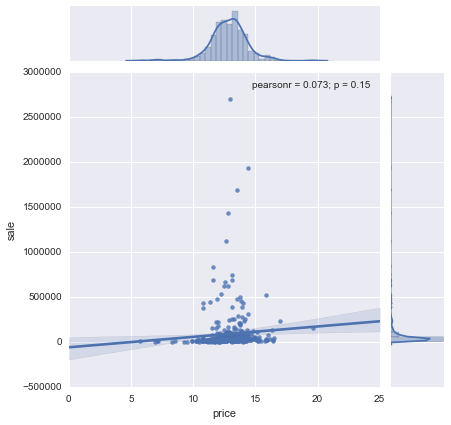

In [12]:
# plot price vs sale, could identify some outliers

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.jointplot(sumdata.price, sumdata.sale, kind='reg')

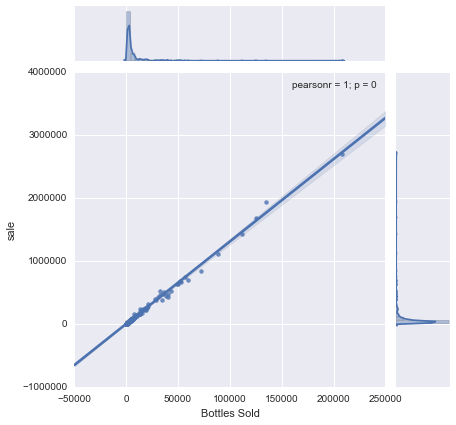

In [13]:
# plot bottles sold vs sale, perfect correlation as expected

sns.jointplot(sumdata['Bottles Sold'], sumdata.sale, kind='reg')

In [14]:
# drop outliers over 3 standard deviation from the mean

import numpy as np
from scipy import stats

modeldata = sumdata[np.abs(stats.zscore(sumdata)<3).all(axis=1)]

# Refine the data

In [15]:
# check the correlation between features

modeldata.corr()

,County Number,season,sale,Volume Sold (Liters),Bottles Sold,price
County Number,1.000000,0.007773,0.057974,0.052634,0.047641,0.070149
season,0.007773,1.000000,-0.050248,-0.063149,-0.051682,0.092015
sale,0.057974,-0.050248,1.000000,0.997190,0.995112,0.100977
Volume Sold (Liters),0.052634,-0.063149,0.997190,1.000000,0.995004,0.094661
Bottles Sold,0.047641,-0.051682,0.995112,0.995004,1.000000,0.057417
price,0.070149,0.092015,0.100977,0.094661,0.057417,1.000000


In [16]:
# assiagn independent and dependent variables, and create dummies for categorical features

from sklearn import metrics
from sklearn import preprocessing

categorical = preprocessing.OneHotEncoder(categorical_features = [0,1])
X = modeldata[['County Number', 'season', 'price', 'Bottles Sold']]
y = modeldata['sale']
X = categorical.fit_transform(X)

# Build your models

In [17]:
# build linear regression with lasso regularization to address multicollinearity problem brought by dummies.
# Since I created n dummies for n categories with OneHotEncoder, there will be perfect multicollinearity.
# By applying Lasso to my model, redundent dummies will be dropped from the model.

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LassoCV, Lasso

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)
lassocv = LassoCV(n_alphas=100, normalize=True, random_state=1)
lassocv.fit(X_train, y_train)

print lassocv.alpha_

y_pred = lassocv.predict(X_test)

print metrics.r2_score(y_test, y_pred)
print np.sqrt(metrics.mean_squared_error(y_test, y_pred))

39.0409124542
0.997916610932
6193.65532705


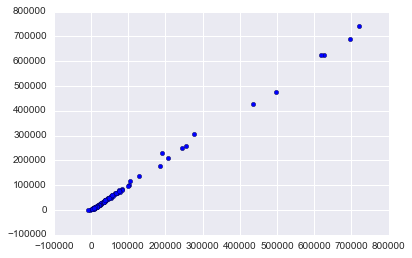

In [18]:
plt.scatter(y_pred, y_test)

In [19]:
# check how the model would perform without bottles sold as independent variable

X = modeldata[['County Number', 'season', 'price']]
y = modeldata['sale']
X = categorical.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

In [20]:
# r2 is still very high without bottles sold, but the rmse is significantly higher, which indicates:
# 1. the model is less predictive without bottles sold
# 2. r2 may not be a good matrics to evaluate a regularized model since the loss function is not solely mse

lassocv = LassoCV(n_alphas=100, normalize=True, random_state=1)
lassocv.fit(X_train, y_train)
print lassocv.alpha_
pred_y = lassocv.predict(X_test)
print metrics.r2_score(y_test, pred_y)
print np.sqrt(metrics.mean_squared_error(y_test, pred_y))

38.6356088095
0.936399829656
34220.8649508
